In [ ]:
# this notebook has results up to 89% in models section

## I&I

In [434]:
import pandas as pd
import numpy as np
import glob
from collections import Counter
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sb
import datetime

from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier

% matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# add auto relaod
%load_ext autoreload
% autoreload 2
from utils import *
from detect_peaks import detect_peaks
    
from sklearn_porter import Porter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [233]:
# https://github.com/nok/sklearn-porter
def port_model(model, name="rf_from_sklearn.cpp"):
    porter = Porter(model, language='c')
    output = porter.export(embed_data=True)

    with open(name, "w") as text_file:
        text_file.write(output)

In [380]:
cd data

/home/gidi/nbs/RoadTrackACC/data


In [381]:
f=glob.glob('*.xlsx')
f

['Acc_Data_Toyota_2604.xlsx',
 'Acc_Test1704.xlsx',
 'CarExp_AccData_2202.xlsx',
 'Acc_Test_240418.xlsx',
 'BUMPERS.xlsx']

In [4]:
# categroies
categories={0:'regular',1:'standstill',2:'zigzag',3:'dirt',4:'bumper',5:'stop'}

In [255]:
# put all sheets here
# ['Acc_Data_Toyota_2604.xlsx',
#  'Acc_Test1704.xlsx',
#  'Acc_Test_240418.xlsx']
category_dict = {'REGULAR DRIVE':0,'Standingstill':1,'Driving':0,'Drive':0,  'Drive_2':0, 'Bumper_Low':4,
                 'Bumper_High':4,   'Bumper_High_2':4,'ZigZag':2,'ZigZag_2':2,
                'Dirty_Road':3, 'Dirty_Road_2':3, 'Small_Bumper':4,'Emergency_stop':5   ,'Emergency_stop_2':5   ,'Reg_Driving1':0
                ,'Bumper_Low_Speed':4 ,'Reg_Driving2':0 ,'Hard_Stop':5,'Bumpers':4 ,'DirtyRoad':3 ,'ZigZag1':2
                ,'ZigZag2':2,'ZigZag3':2,'BUMPERS1':4}

In [151]:
big_df = load_data(['Acc_Data_Toyota_2604.xlsx', 'Acc_Test_240418.xlsx','BUMPERS.xlsx'])


['Acc_Data_Toyota_2604.xlsx', 'Acc_Test_240418.xlsx', 'BUMPERS.xlsx']
Acc_Data_Toyota_2604.xlsx
Acc_Test_240418.xlsx
BUMPERS.xlsx


KeyError: 'BUMPERS1'

['Acc_Data_Toyota_2604.xlsx']
['Acc_Test_240418.xlsx']
['BUMPERS.xlsx']


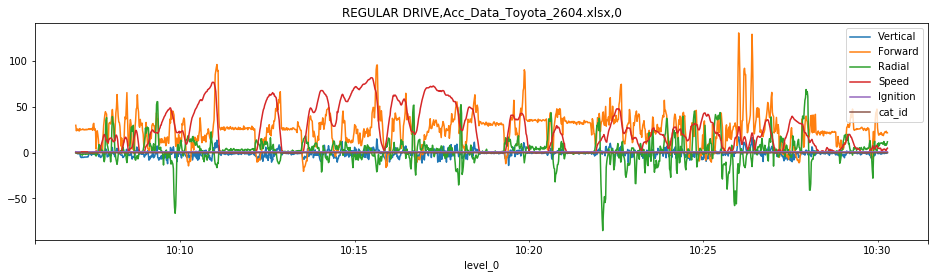

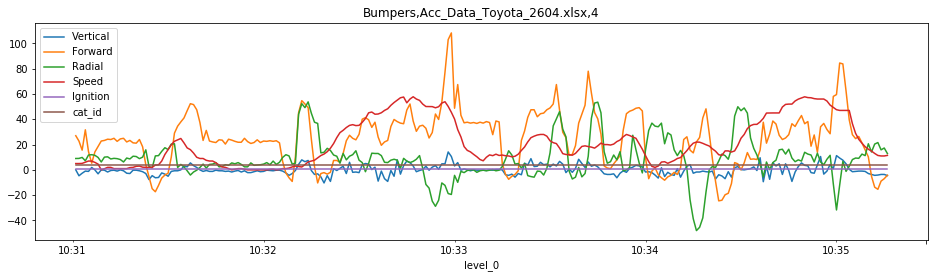

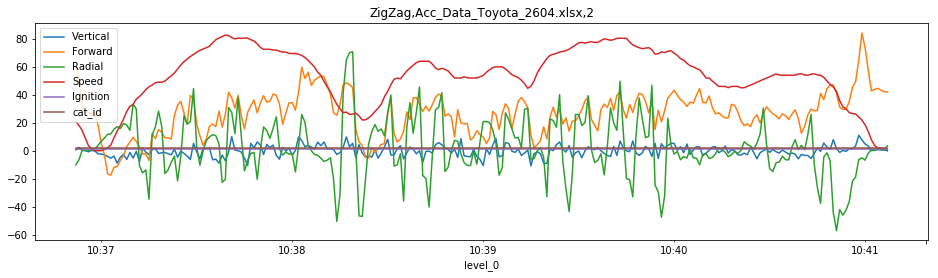

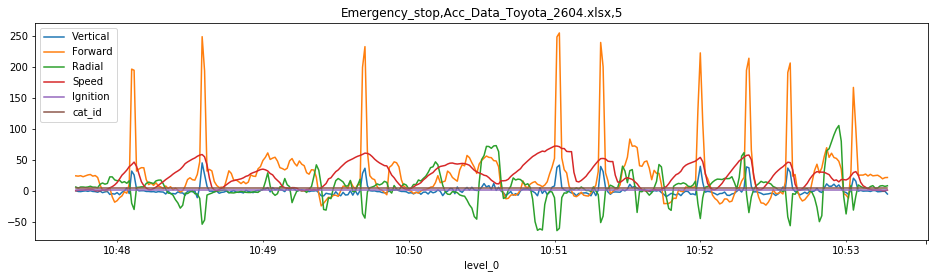

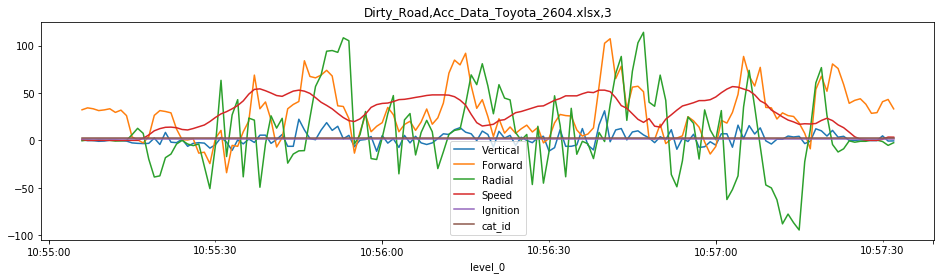

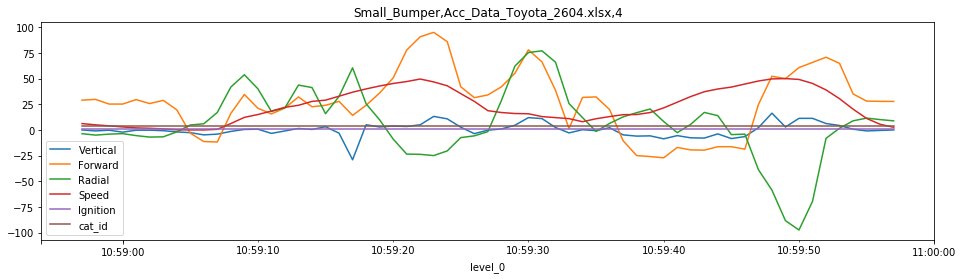

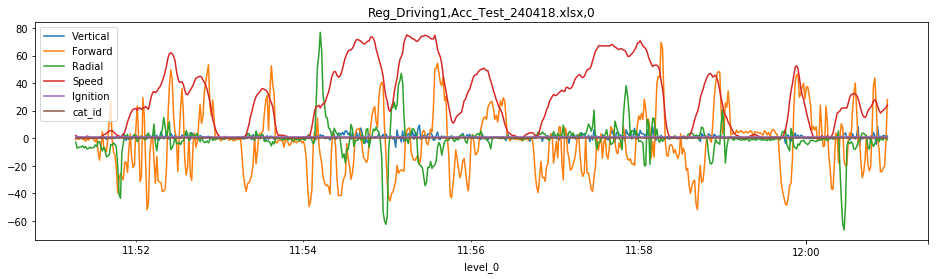

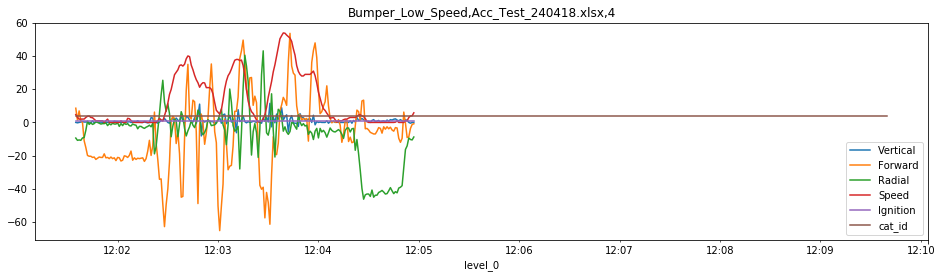

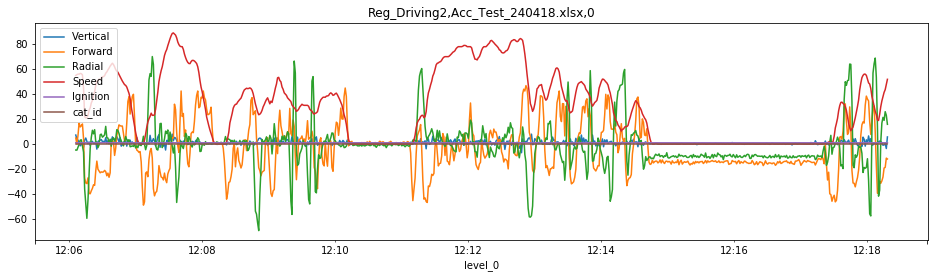

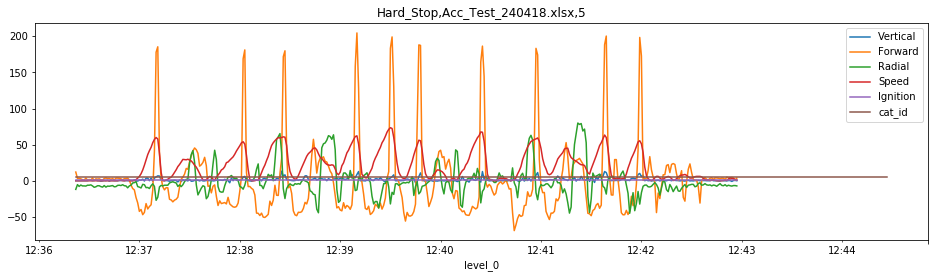

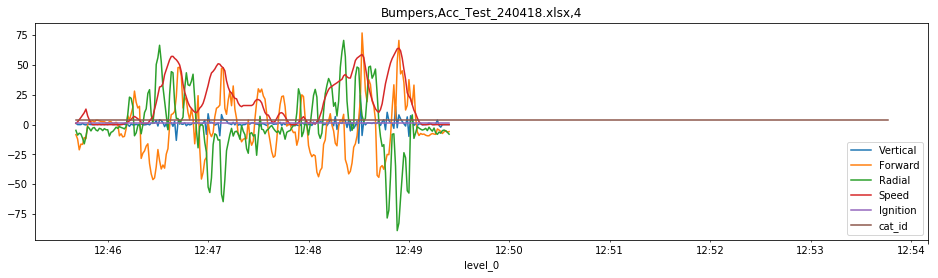

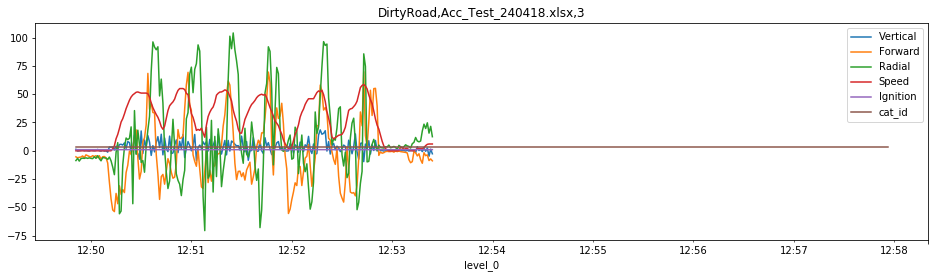

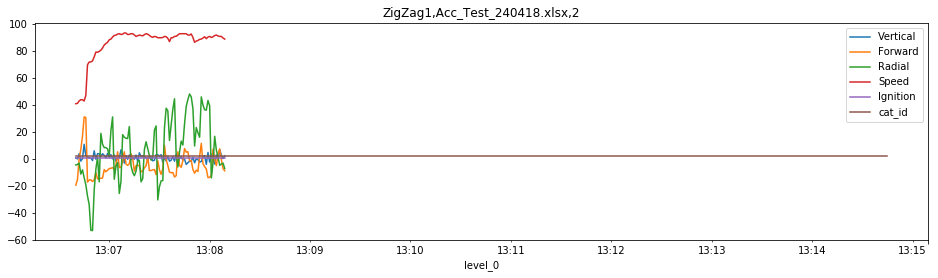

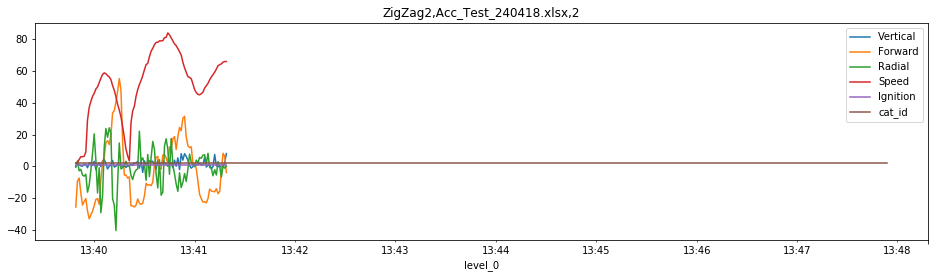

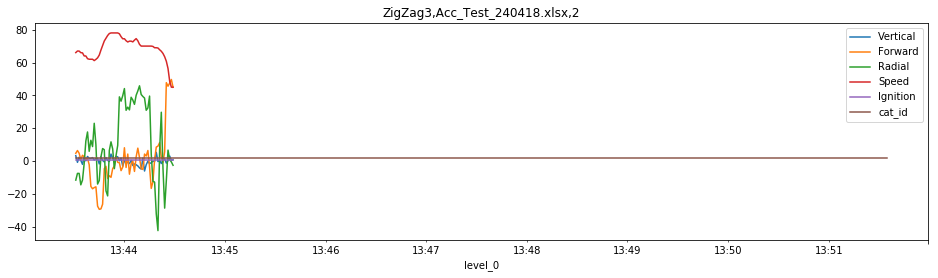

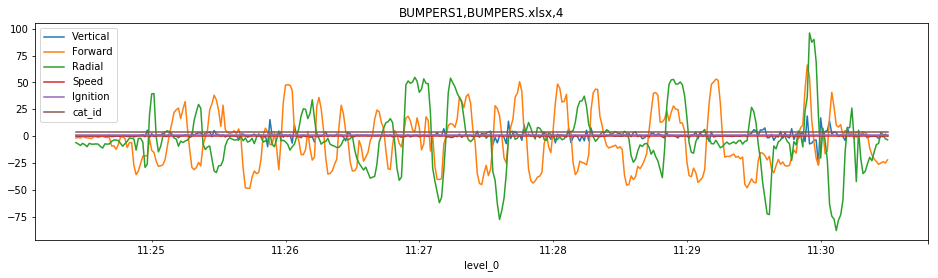

In [257]:
# load multiple files - moved to utils, but still can be used here

df_list=[]
df_dict={}
big_df=pd.DataFrame()

for file_id in ['Acc_Data_Toyota_2604.xlsx','Acc_Test_240418.xlsx','BUMPERS.xlsx']:
    print([file_id])

    excel=pd.ExcelFile(file_id)
    hz=50 if file_id!=1 else 100

    features=['Vertical','Forward','Radial','Speed','Ignition','level_0']
    numeric_features=['Vertical','Forward','Speed','Radial']

    for i,name in enumerate(excel.sheet_names):
        df = excel.parse(name,header=1)
        df = df.reset_index()
        df.columns=[column.replace(' ','') for column in df.columns]
        df[numeric_features] = df[numeric_features].apply(pd.to_numeric, errors='coerce')
        df = df[features]#
        df.Vertical = df.Vertical + 240 # normalize" weritcal Axis
        
        start = pd.Timestamp(df['level_0'][0].replace(']','')) # "resample" time
        end = start+ pd.Timedelta(milliseconds=1000/hz*len(df))
        t = np.linspace(start.value, end.value, len(df))
        t = pd.to_datetime(t)
        df['level_0'] = t
        #ax = df.plot(title=name)

        df = df.set_index(df['level_0']) # add more columns
        df['file'] = file_id
        df['sheet'] = name
        df['cat_id'] = category_dict[name]
                
        big_df=big_df.append(df) # put it all in big_df
        df_list.append(df)
        df.resample('s').mean().plot(title = name+','+file_id+','+str(category_dict[name]),figsize=(16,4)) # resample by the second

In [160]:
features

['Vertical', 'Forward', 'Radial', 'Speed', 'Ignition', 'level_0']

## Parse

In [442]:
big_df['time_sec'] = big_df.index.round('s') # add rounded second column

In [44]:
big_df=big_df.dropna()

### annotation file(s)

In [46]:
# read annotation file

f = glob.glob('*.csv')

anot={}

anot = pd.read_csv(f[0])
    
hard_stops = anot[anot.event=='hard_stop']
# fit date time format. first workout hard stops
hard_stops['start time']=pd.to_datetime(hard_stops['start time'])
hard_stops['end time']=pd.to_datetime(hard_stops['end time'])
anot.keys()

Index(['file', 'sheet', 'event', 'start time', 'end time', 'start row',
       'end row'],
      dtype='object')

In [47]:
# importent! make a list of hard stops

hard_stop_list=[]
first_second_stop = []
for row in hard_stops.iterrows():
    i=0
    time = row[1]['start time']
    first_second_stop.append(time)
    while time >= row[1]['start time'] and time<=row[1]['end time']:
        hard_stop_list.append(time)
        time=row[1]['start time']+datetime.timedelta(0,i) 
        i+=1

In [48]:
len(hard_stop_list) #115 #201

201

In [49]:
# set hard stops annotations
big_df['hard_stop_on']=0
big_df['hard_stop_on']\
[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)&(big_df.time_sec.isin(hard_stop_list))]=1
big_df['hard_stop_on']\
[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)&(big_df.time_sec.isin(first_second_stop))]=2

In [50]:
print(len(big_df[big_df.hard_stop_on>1]))
len(big_df) #438921
len(big_df[big_df['cat_id']==5]) #28,264

799


36396

In [56]:
for sheet in big_df.sheet.unique():
    print(sheet)

REGULAR DRIVE
Bumpers
ZigZag
Emergency_stop
Dirty_Road
Small_Bumper
Reg_Driving1
Bumper_Low_Speed
Reg_Driving2
Hard_Stop
DirtyRoad
ZigZag1
ZigZag2
ZigZag3


### Annotate/detect emergency stop

In [62]:
hard_Stop_threshold = -7

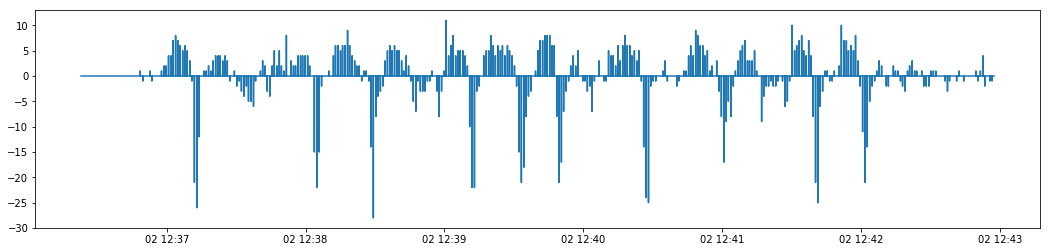

In [40]:
fig,ax = plt.subplots(figsize=(18,4))
ax.plot(big_df[big_df['cat_id']==5].index, big_df[big_df['cat_id']==5]['Speed'].diff())

Emergency_stop
Hard_Stop


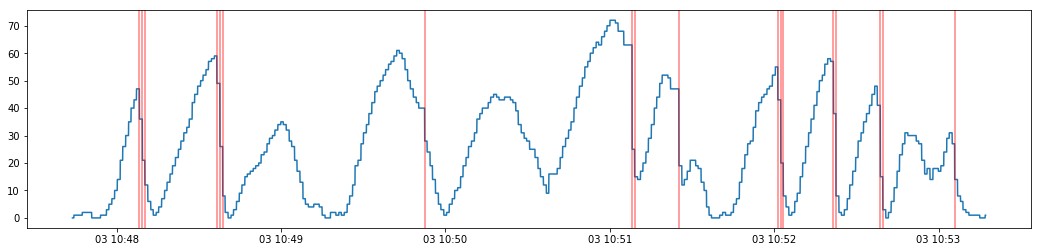

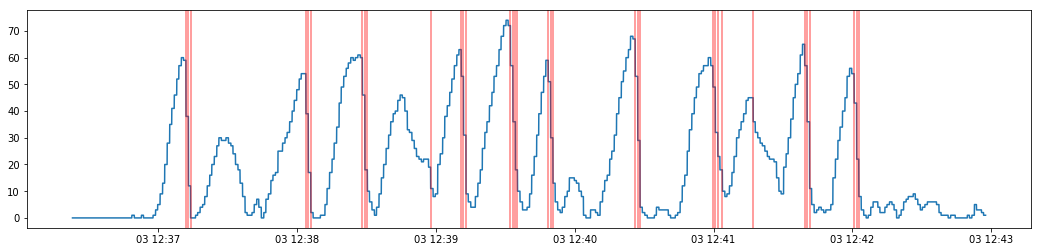

In [61]:
# emergency stops sheet speed drops
for sheet in big_df[big_df['cat_id']==5].sheet.unique():
    print(sheet)
    fig,ax = plt.subplots(figsize=(18,4))
    df = big_df[(big_df['cat_id']==5)&(big_df.sheet==sheet)]
    ax.plot(df.index, df['Speed'])

    #for stop in hard_stop_list[:115]:
    for stop in df['Speed'].diff().iteritems():
        if stop[1]<hard_Stop_threshold:
            ax.axvline(x=stop[0], color='r',alpha=0.5)


REGULAR DRIVE
Reg_Driving1
Reg_Driving2


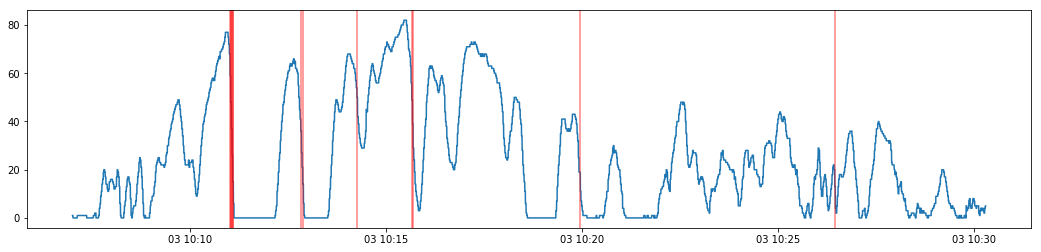

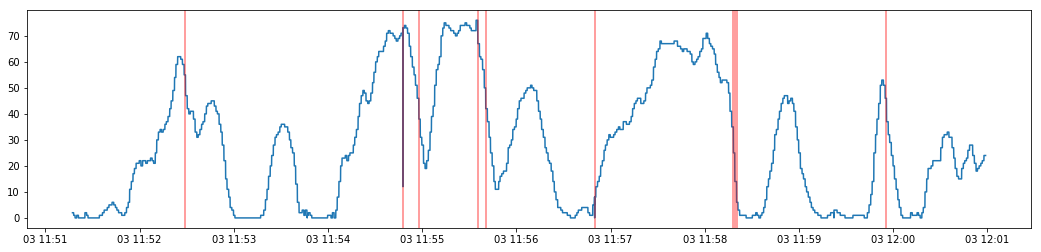

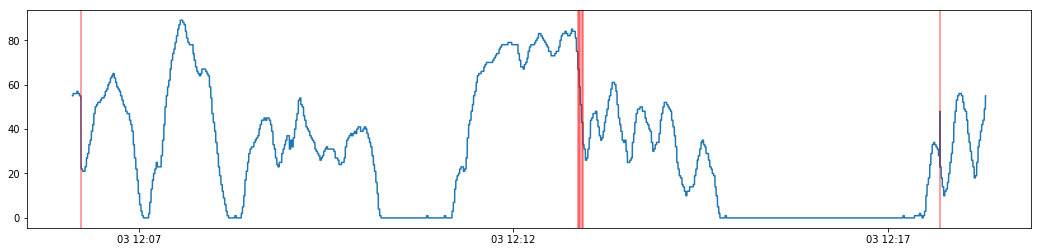

In [383]:
# standard drive speed drops

for sheet in big_df[big_df['cat_id']==0].sheet.unique():
    print(sheet)
    fig,ax = plt.subplots(figsize=(18,4))
    df = big_df[(big_df['cat_id']==0)&(big_df.sheet==sheet)]
    ax.plot(df.index, df['Speed'])

    #for stop in hard_stop_list[:115]:
    for stop in df['Speed'].diff().iteritems():
        if stop[1]<hard_Stop_threshold:
            ax.axvline(x=stop[0], color='r',alpha=0.5)


In [386]:
big_df[big_df['cat_id']==5].sheet.unique()

array(['Emergency_stop', 'Hard_Stop'], dtype=object)

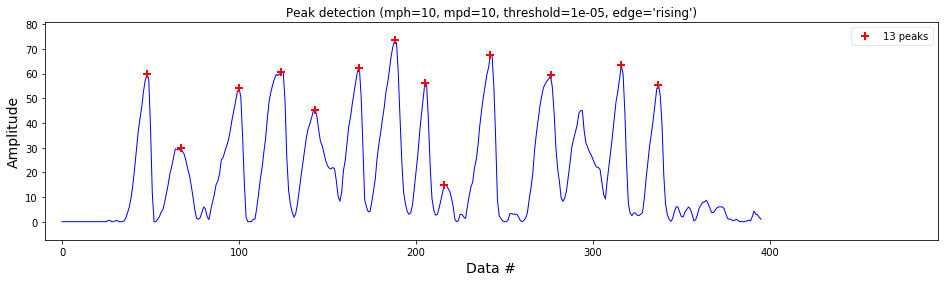

array([ 48,  67, 100, 124, 143, 168, 188, 205, 216, 242, 276, 316, 337])

Emergency_stop


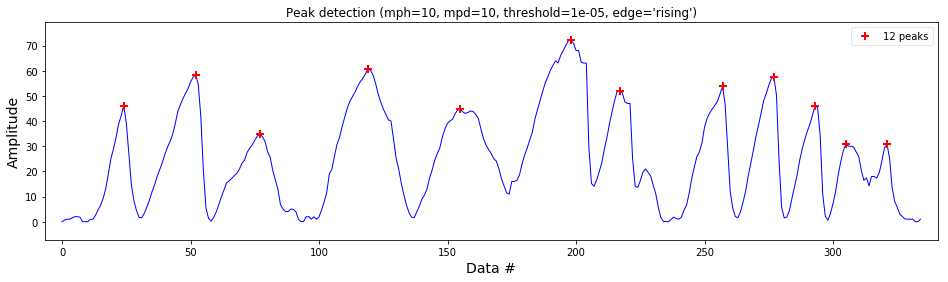

Hard_Stop


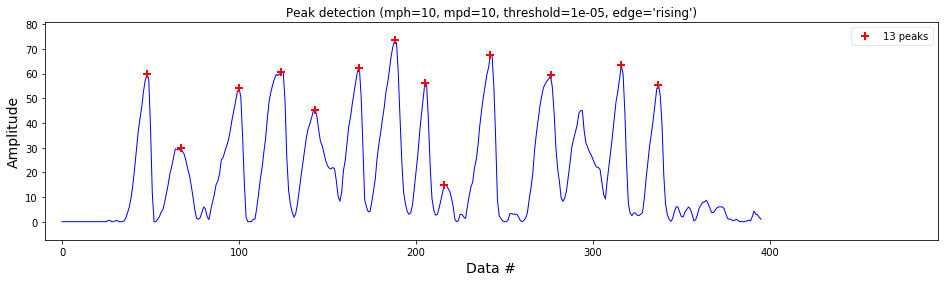

In [429]:
# predict peaks
for sheet in big_df[big_df['cat_id']==5].sheet.unique():
    print(sheet)
    #fig,ax = plt.subplots(figsize=(18,4))
    df = big_df[(big_df['cat_id']==5)&(big_df.sheet==sheet)]
    #ax.plot(df.index, df['Speed'])
    detect_peaks(np.array(df.Speed.resample('s')),mph=10,mpd=10, threshold = 0.00001, show=True)

### Annotate bumpers

In [358]:
bupmer_list=[1.20,1.25,2.29,3.05,3.21,3.25,5.02,5.07,5.10,5.14,5.17,5.23]
# ???

In [365]:
seconds=int(bupmer_list[0])*60+(bupmer_list[0]-int(bupmer_list[0]))*100
row=seconds*50

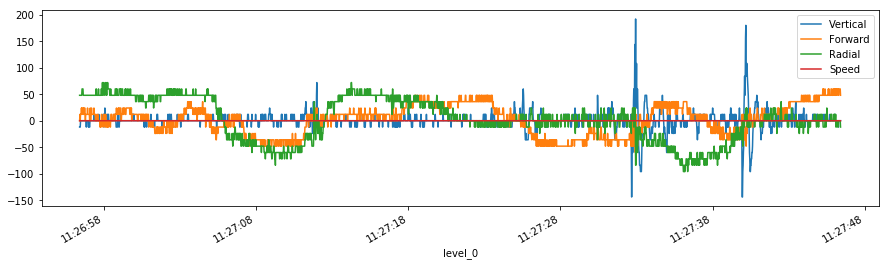

In [372]:
df[features[:4]][7500:10000].plot(figsize=(15,4)) 

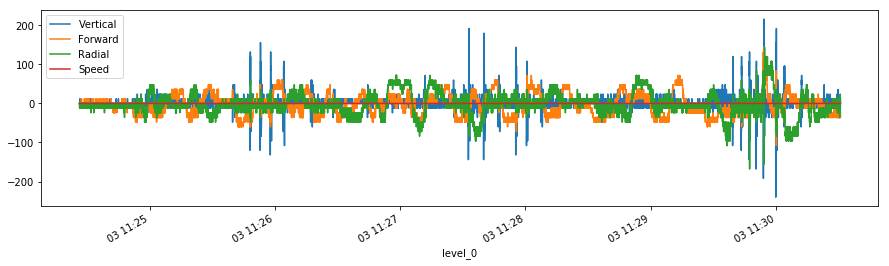

In [373]:
# bumpers
df[features[:4]].plot(figsize=(15,4)) 

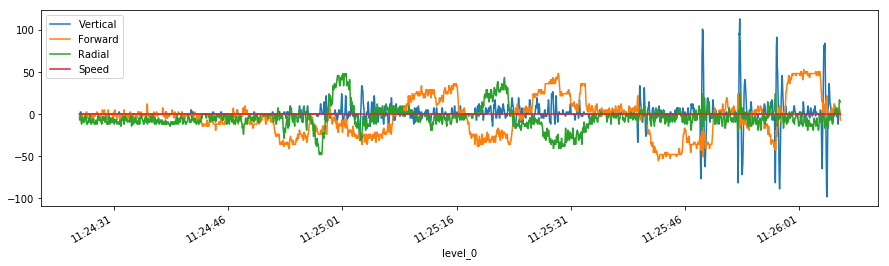

In [354]:
pd.rolling_mean(df[features[:4]][:5000],5).plot(figsize=(15,4)) 

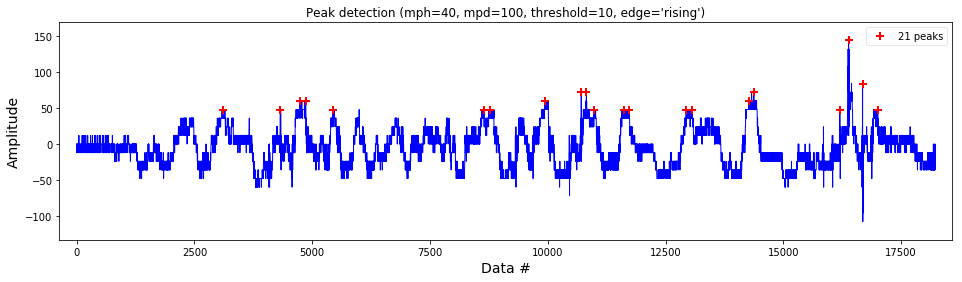

array([ 3107,  4324,  4739,  4862,  5435,  8643,  8781,  9948, 10711,
       10820, 10987, 11611, 11723, 12937, 13068, 14271, 14374, 16199,
       16385, 16682, 17004])

In [377]:
 detect_peaks(np.array(df.Forward),mph=40,mpd=100, threshold = 10, show=True)

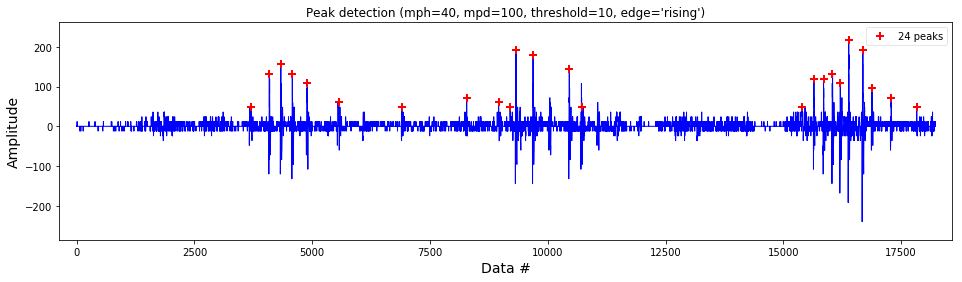

array([ 3710,  4091,  4334,  4578,  4896,  5565,  6903,  8279,  8957,
        9201,  9326,  9688, 10457, 10722, 15396, 15650, 15854, 16043,
       16210, 16388, 16688, 16883, 17292, 17832])

In [376]:
 detect_peaks(np.array(df.Vertical),mph=40,mpd=100, threshold = 10, show=True)

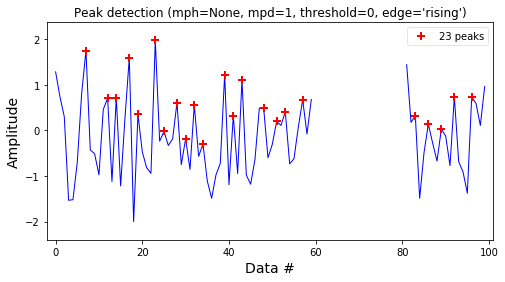

[ 7 12 14 17 19 23 25 28 30 32 34 39 41 43 48 51 53 57 83 86 89 92 96]


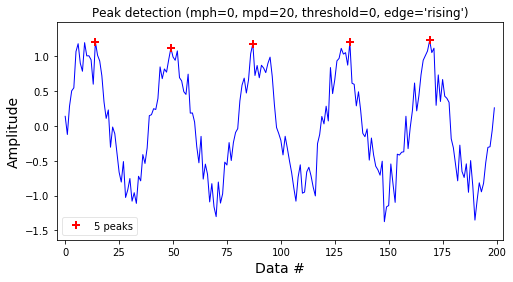

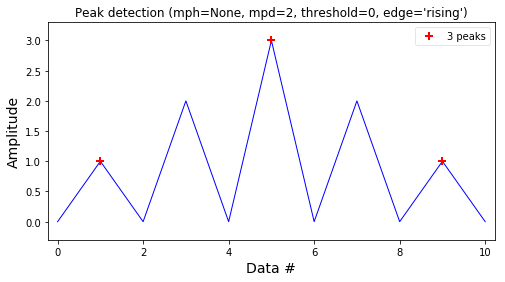

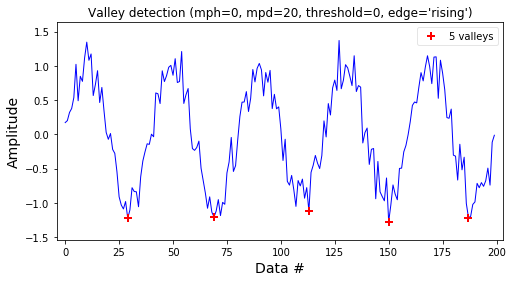

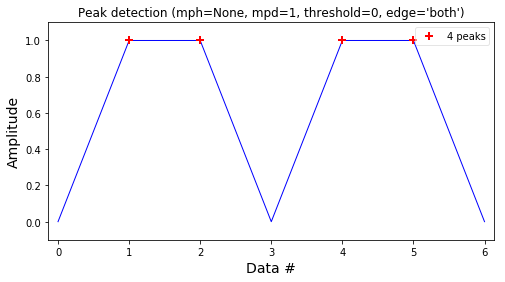

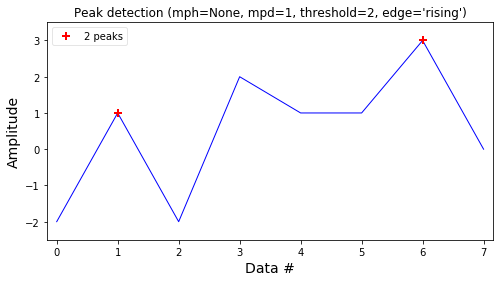

array([1, 6])

In [320]:
#https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
    
# example
 x = np.random.randn(100)
 x[60:81] = np.nan
 # detect all peaks and plot data
 ind = detect_peaks(x, show=True)
 print(ind)

 x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
 # set minimum peak height = 0 and minimum peak distance = 20
 detect_peaks(x, mph=0, mpd=20, show=True)

 x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
 # set minimum peak distance = 2
 detect_peaks(x, mpd=2, show=True)

 x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
 # detection of valleys instead of peaks
 detect_peaks(x, mph=0, mpd=20, valley=True, show=True)

 x = [0, 1, 1, 0, 1, 1, 0]
 # detect both edges
 detect_peaks(x, edge='both', show=True)

 x = [-2, 1, -2, 2, 1, 1, 3, 0]
 # set threshold = 2
 detect_peaks(x, threshold = 2, show=True)

## Models

### Extract features

In [443]:
big_df.head()

,Vertical,Forward,Radial,Speed,Ignition,level_0,file,sheet,cat_id,time_sec
level_0,,,,,,,,,,
2018-05-03 10:07:00.964000000,0.0,24.0,0.0,1.0,1.0,2018-05-03 10:07:00.964000000,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,2018-05-03 10:07:01
2018-05-03 10:07:00.984000256,0.0,36.0,0.0,1.0,1.0,2018-05-03 10:07:00.984000256,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,2018-05-03 10:07:01
2018-05-03 10:07:01.004000512,0.0,36.0,0.0,1.0,1.0,2018-05-03 10:07:01.004000512,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,2018-05-03 10:07:01
2018-05-03 10:07:01.024000768,0.0,24.0,0.0,1.0,1.0,2018-05-03 10:07:01.024000768,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,2018-05-03 10:07:01
2018-05-03 10:07:01.044001024,0.0,24.0,-12.0,1.0,1.0,2018-05-03 10:07:01.044001024,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,2018-05-03 10:07:01


In [445]:
# extract features
features=['Vertical','Radial','Forward']
research_dfa = big_df.groupby('time_sec')[features].mean()\
    .join(big_df.groupby('time_sec')[features].std(), rsuffix='_std')\
    .join(big_df.groupby('time_sec')[features].max(), rsuffix='_max')\
    .join(big_df.groupby('time_sec')[features].min(), rsuffix='_min')\
    .join(big_df.groupby('time_sec')['cat_id'].max())#\
   # .join(big_df.groupby('time_sec')['hard_stop_on'].max())
    
research_dfa = research_dfa.fillna(0)

In [446]:
pred_features = features + ['Vertical_std','Radial_std','Forward_std',\
                'Speed_std','Vertical_max','Radial_max','Forward_max','Speed_max','Vertical_min','Radial_min',\
                            'Forward_min','Speed_min']

In [119]:
shifted_features=[feature+'_shifted' for feature in pred_features]

In [141]:
# shift 
research_dfa=research_dfa.join(research_dfa.shift(-1),rsuffix='_shifted')
research_dfa = research_dfa.fillna(0)

In [111]:
std_features = ['Vertical_std','Radial_std','Forward_std']

In [69]:
# optional: make shift
# research_dfas=research_dfa.shift().join(research_dfa,lsuffix='l')#.dropna()

In [134]:
Counter(research_dfa.cat_id)

Counter({0: 2712, 2: 496, 3: 362, 4: 745, 5: 730})

In [430]:
research_dfa.head()

,Vertical,Radial,Forward,Speed,Vertical_std,Radial_std,Forward_std,Speed_std,Vertical_max,Radial_max,...,Vertical_max_shifted,Radial_max_shifted,Forward_max_shifted,Speed_max_shifted,Vertical_min_shifted,Radial_min_shifted,Forward_min_shifted,Speed_min_shifted,cat_id_shifted,hard_stop_on_shifted
time_sec,,,,,,,,,,,,,,,,,,,,,
2018-05-03 10:07:01,-0.461538,-1.384615,25.384615,1.00,2.353394,3.909751,3.909751,0.000000,0.0,0.0,...,12.0,12.0,36.0,1.0,0.0,-12.0,12.0,0.0,0.0,0.0
2018-05-03 10:07:02,0.240000,-0.240000,23.760000,0.18,1.697056,2.959316,4.529090,0.388088,12.0,12.0,...,12.0,0.0,36.0,0.0,-12.0,-12.0,12.0,0.0,0.0,0.0
2018-05-03 10:07:03,-1.680000,-0.720000,27.120000,0.00,4.854789,2.878775,6.326620,0.000000,12.0,0.0,...,0.0,0.0,36.0,0.0,0.0,-12.0,12.0,0.0,0.0,0.0
2018-05-03 10:07:04,0.000000,-0.720000,24.720000,0.00,0.000000,2.878775,4.476879,0.000000,0.0,0.0,...,12.0,0.0,36.0,0.0,-12.0,-12.0,12.0,0.0,0.0,0.0
2018-05-03 10:07:05,-1.440000,-0.240000,24.960000,0.00,4.625396,1.697056,4.750768,0.000000,12.0,0.0,...,0.0,12.0,36.0,0.0,-12.0,0.0,12.0,0.0,0.0,0.0


### compare models

In [223]:
trn,test = train_test_split(research_dfa[research_dfa.cat_id<4],random_state=1)
len(trn), len(test)

(2677, 893)

In [248]:
research_dfb = research_dfa[research_dfa.cat_id<4]

In [ ]:
# model selection
# second level models


# multi layer perceptron - neural network
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(15, 10), random_state=1)
lr = LogisticRegression()
svc = svm.SVC(decision_function_shape='ovo')
# tree based models
et = ExtraTreesClassifier(n_estimators=15, random_state=0)
base_estimator = DecisionTreeClassifier(random_state=0)
ada = AdaBoostClassifier(n_estimators=100,random_state=0)
rf = RandomForestClassifier(n_estimators=50,max_depth=10, oob_score=True, random_state=1)

models = [lr,svc, mlp,rf,ada,et]
model_names = ['lr','svc', 'mlp', 'random forest', 'ada', 'extra tree']

for i, model in enumerate(models):
    results=[]
    for samples_train, samples_test in kf.split(research_dfb):
        # SVM is much slower
        X_train,X_valid, y_train,y_valid = research_dfb[pred_features].iloc[samples_train],\
        research_dfb[pred_features].iloc[samples_test]\
        ,research_dfb.cat_id[samples_train],research_dfb.cat_id[samples_test]
        model.fit(X_train,y_train)
        results.append(model.score(X_valid,y_valid))
    print(model_names[i],round(np.mean(results),3),round(np.std(results),3))

lr 0.854 0.01
svc 0.764 0.006


In [480]:
port_model(lr,'lr.cpp')

ValueError: Currently the given estimator 'LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)' isn't supported.

In [447]:
model_names[i]

IndexError: list index out of range

In [448]:
model = RandomForestClassifier(n_estimators=20, oob_score=True, random_state=1,class_weight)
port_model(model,'random_forset')

AttributeError: 'RandomForestClassifier' object has no attribute 'estimators_'

In [486]:
# grid search for random forest
# 50 yields best value for money
import itertools
models=[]
for est,depth in itertools.product([5,10,20,50,100,200],[2,5,7,10,15]):
    model = RandomForestClassifier(n_estimators=est,max_depth=depth, oob_score=False, random_state=1,\
                                  )
    results=[]
    models.append(model)
    for samples_train, samples_test in kf.split(research_dfb):
        # SVM is much slower
        X_train,X_valid, y_train,y_valid = research_dfb[pred_features].iloc[samples_train],\
        research_dfb[pred_features].iloc[samples_test]\
        ,research_dfb.cat_id[samples_train],research_dfb.cat_id[samples_test]
        model.fit(X_train,y_train)
        results.append(model.score(X_valid,y_valid))
    print(est, depth,round(np.mean(results),3),round(np.std(results),3))

5 2 0.822 0.013
5 5 0.865 0.012
5 7 0.867 0.012
5 10 0.871 0.011
5 15 0.866 0.006
10 2 0.819 0.008
10 5 0.869 0.013
10 7 0.869 0.013
10 10 0.875 0.01
10 15 0.875 0.009
20 2 0.822 0.009
20 5 0.871 0.009
20 7 0.875 0.009
20 10 0.877 0.011
20 15 0.887 0.007
50 2 0.82 0.007
50 5 0.871 0.01
50 7 0.876 0.011
50 10 0.878 0.011
50 15 0.885 0.007
100 2 0.821 0.007
100 5 0.871 0.009
100 7 0.873 0.01
100 10 0.879 0.012
100 15 0.889 0.008
200 2 0.821 0.007
200 5 0.871 0.01
200 7 0.874 0.01
200 10 0.878 0.011
200 15 0.889 0.008


In [487]:
models[14]

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [488]:
port_model(models[14],'rf_20_15.cpp')

In [466]:
models=[]
for i in [5,10,15,50]:
    model =  ExtraTreesClassifier(n_estimators=i, random_state=0)
    results=[]
    models.append(model)
    for samples_train, samples_test in kf.split(research_dfb):
        # SVM is much slower
        X_train,X_valid, y_train,y_valid = research_dfb[pred_features].iloc[samples_train],\
        research_dfb[pred_features].iloc[samples_test]\
        ,research_dfb.cat_id[samples_train],research_dfb.cat_id[samples_test]
        model.fit(X_train,y_train)
        results.append(model.score(X_valid,y_valid))
    print(i,round(np.mean(results),3),round(np.std(results),3))

5 0.866 0.011
10 0.876 0.008
15 0.873 0.012
50 0.876 0.012


In [459]:
model[2]

ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, random_state=924231285,
          splitter='random')

In [461]:
port_model(models[2],'et_15.cpp')

In [253]:
# feature importence
pd.DataFrame([(i,j) for (i,j) in zip(et.feature_importances_,pred_features+shifted_features)],columns=['importence','feature'])\
    .sort_values(by='importence',ascending=False)

,importence,feature
5,0.109175,Radial_std
4,0.094922,Vertical_std
6,0.092089,Forward_std
15,0.082576,Speed_min
3,0.079837,Speed
11,0.073405,Speed_max
1,0.067661,Radial
8,0.065164,Vertical_max
9,0.050454,Radial_max
13,0.047489,Radial_min


## Plots

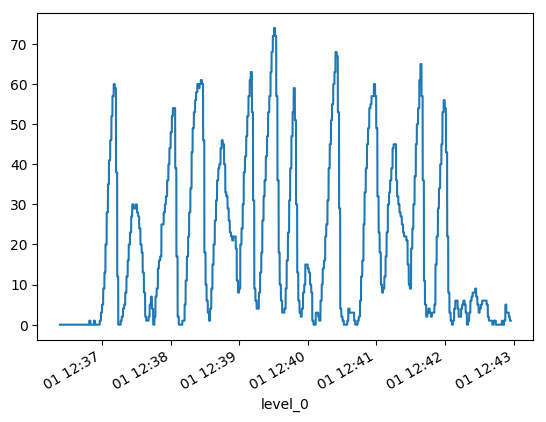

In [256]:
big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)]['Speed'].plot()

In [324]:
# ad ma column
big_df['speed_ma_100']\
=pd.rolling_mean(big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)]['Speed'],100).fillna(0)

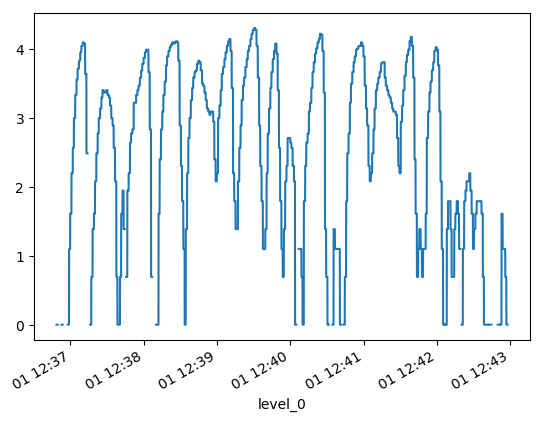

In [258]:
big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)]['Speed'].apply(lambda x:np.log(np.abs(x))).plot()

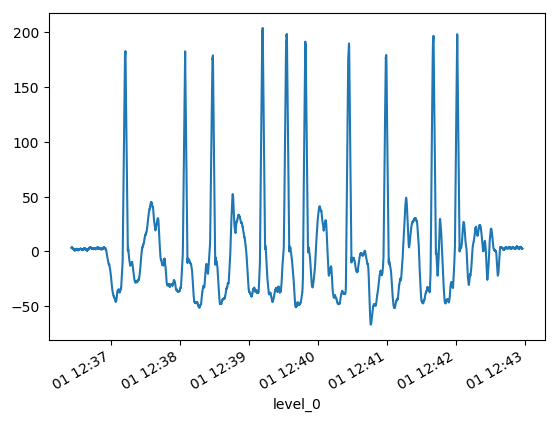

In [225]:
pd.rolling_mean(big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)]['Forward'],100).plot()

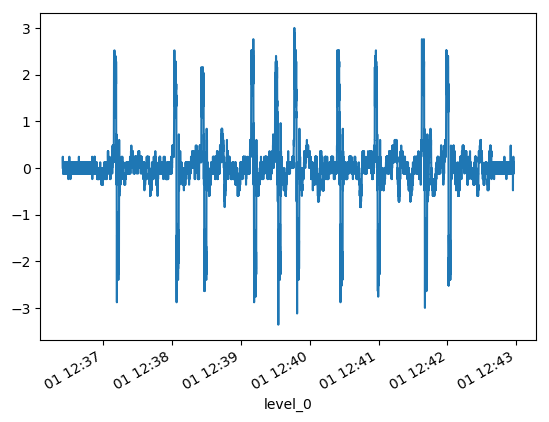

In [236]:
pd.rolling_mean(big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)]['Forward'],100).diff().plot()

In [241]:
sum(pd.rolling_mean(big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)]['Forward'],100).diff()>1)

1010

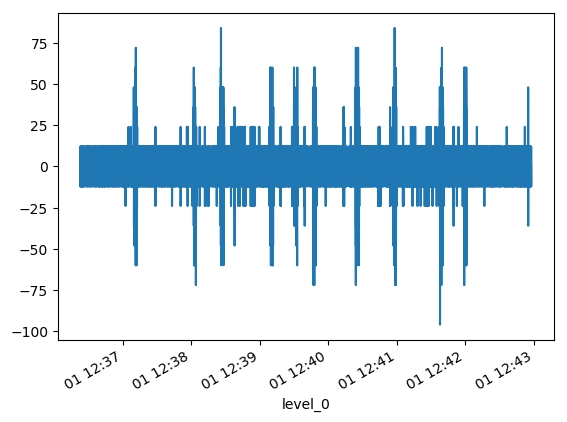

In [237]:
big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)]['Forward'].diff().plot()

In [239]:
sum(big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)]['Forward'].diff()>50)

22

### Annotate stops

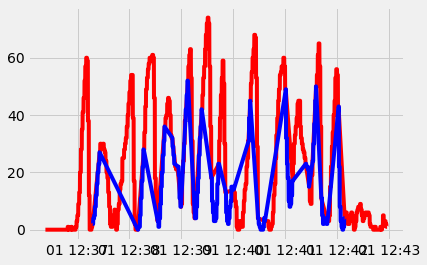

In [200]:

plt.plot(big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)&(big_df['hard_stop_on']==0)]['Speed'], color='r')
plt.plot(big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)&(big_df['hard_stop_on']==1)]['Speed'], color='b')
plt.show()

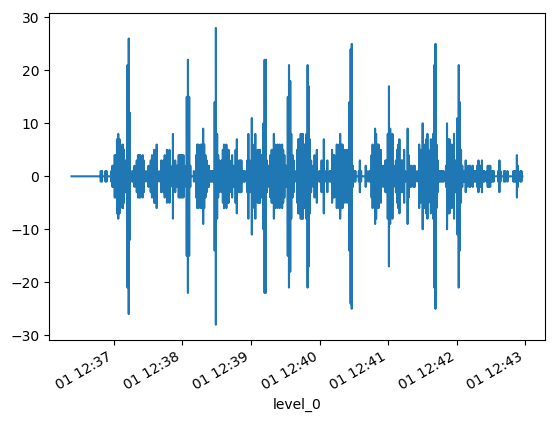

In [221]:
big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)].Speed.diff().diff().plot()

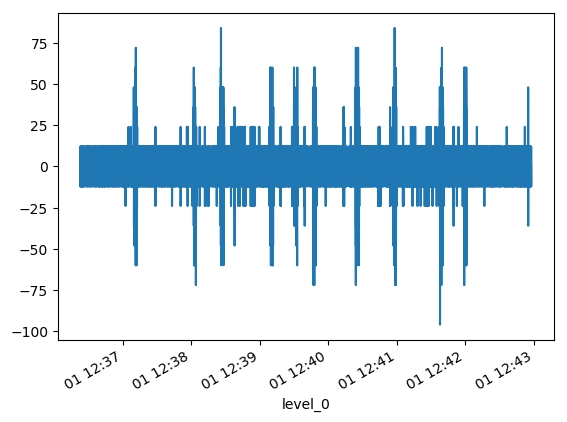

In [234]:
big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)].Forward.diff().plot()

In [187]:
len(big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)].isna())

24236

In [93]:
# move to sql to tag hardstops correctly
#or generate another table

In [130]:
import datetime
hard_stops['start time'].iloc[0]+ datetime.timedelta(0,1) 

Timestamp('2018-05-01 12:37:18')

In [215]:
np.mean(big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)&(big_df['hard_stop_on']==1)]['Speed'])

14.284299858557285

In [224]:
np.mean(big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df['hard_stop_on']==0)]['Speed'])

29.64387046907457

In [223]:
np.mean(big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df['hard_stop_on']==1)]['Speed'].diff())

0.0004042037186742118

In [287]:
speed=big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)]['Speed']

In [274]:
big_df['speed_diff'] = big_df['Speed'] - big_df['Speed'].shift()  

In [275]:
big_df['speed_diff_1']=big_df['speed_diff'] .shift(1)

## Time series statistcs

In [ ]:
# takes some time
# Examine join distribution
sb.jointplot('speed_diff_1', 'speed_diff', big_df, kind='reg', size=4)

In [278]:
# test auto correlcation
# takes some time
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
lag_correlations = acf(big_df['speed_diff'].iloc[1:])  
lag_partial_correlations = pacf(big_df['speed_diff'].iloc[1:])

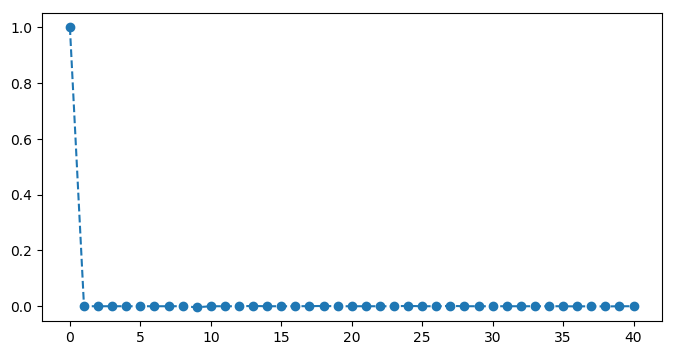

In [282]:
fig, ax = plt.subplots(figsize=(8,4))  
ax.plot(lag_correlations, marker='o', linestyle='--')

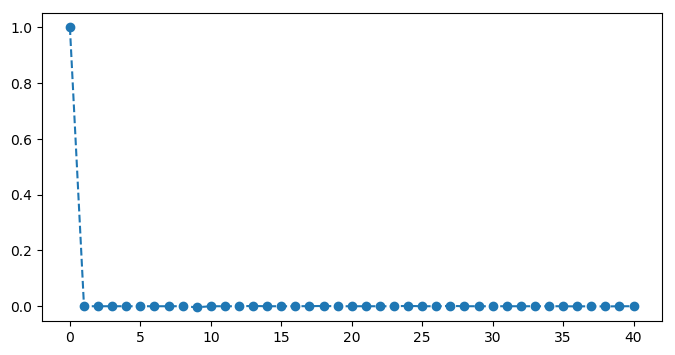

In [284]:
fig, ax = plt.subplots(figsize=(8,4))  
ax.plot(lag_partial_correlations, marker='o', linestyle='--')

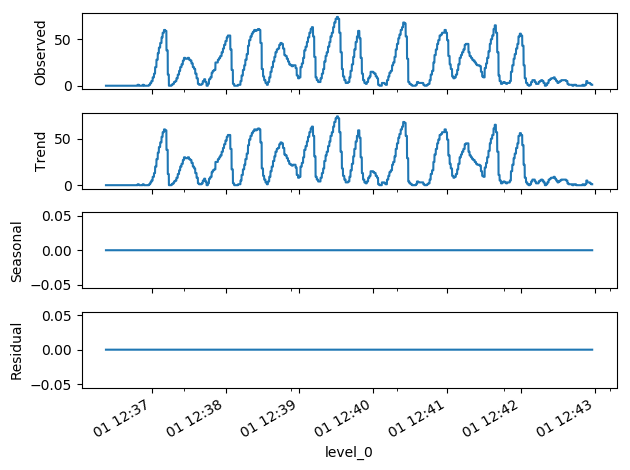

In [290]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(speed, model='additive', freq=1)  
fig = plt.figure()  
fig = decomposition.plot()

In [326]:
model

In [329]:
results.fittedvalues[300:320]

level_0
2018-05-01 12:36:28.946249216    0.000139
2018-05-01 12:36:28.966249984    0.000139
2018-05-01 12:36:28.986250752    0.000139
2018-05-01 12:36:29.006251520    0.000139
2018-05-01 12:36:29.026252288    0.000139
2018-05-01 12:36:29.046253312    0.000139
2018-05-01 12:36:29.066254080    0.000139
2018-05-01 12:36:29.086254848    0.000139
2018-05-01 12:36:29.106255616    0.000139
2018-05-01 12:36:29.126256640    0.000139
2018-05-01 12:36:29.146257408    0.000139
2018-05-01 12:36:29.166258176    0.000139
2018-05-01 12:36:29.186258944    0.000139
2018-05-01 12:36:29.206259712    0.000139
2018-05-01 12:36:29.226260736    0.000139
2018-05-01 12:36:29.246261504    0.000139
2018-05-01 12:36:29.266262272    0.000139
2018-05-01 12:36:29.286263040    0.000139
2018-05-01 12:36:29.306264064    0.000139
2018-05-01 12:36:29.326264832    0.000139
dtype: float64

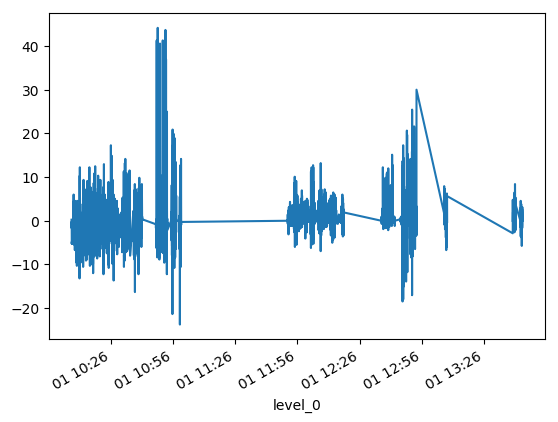

In [334]:
research_dfa.Vertical.iloc[1:].plot()

In [336]:
big_df.keys()

Index(['Vertical', 'Forward', 'Radial', 'Speed', 'Ignition', 'level_0', 'file',
       'sheet', 'cat_id', 'hard_stop_on', 'speed_diff', 'speed_diff_1',
       'speed_ma_100'],
      dtype='object')

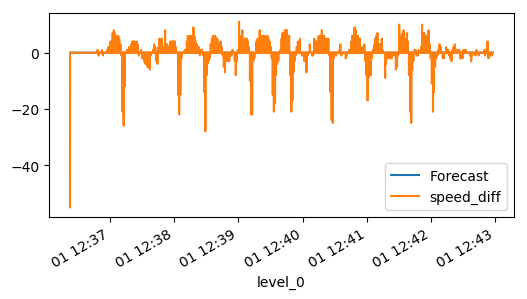

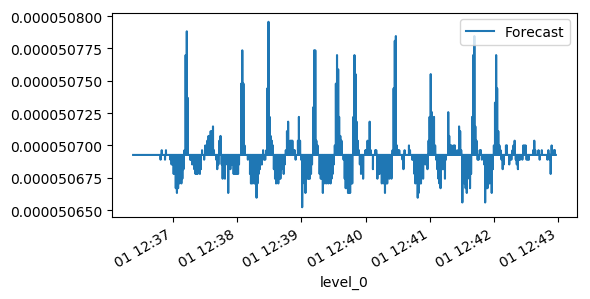

In [341]:
import statsmodels.api as sm 

data=big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)]
model = sm.tsa.ARIMA(data['speed_diff'].iloc[1:], order=(1, 0, 0))  
results = model.fit(disp=-1)  

data['Forecast'] = results.fittedvalues  
data[['Forecast','speed_diff']].plot(figsize=(6, 3))
data[['Forecast']].plot(figsize=(6, 3))

In [342]:
big_df.head()

,Vertical,Forward,Radial,Speed,Ignition,level_0,file,sheet,cat_id,hard_stop_on,speed_diff,speed_diff_1,speed_ma_100
level_0,,,,,,,,,,,,,
2018-05-01 10:07:00.964000000,0.0,24.0,0.0,1.0,1.0,2018-05-01 10:07:01,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,0,NaN,NaN,NaN
2018-05-01 10:07:00.984000256,0.0,36.0,0.0,1.0,1.0,2018-05-01 10:07:01,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,0,0.0,NaN,NaN
2018-05-01 10:07:01.004000512,0.0,36.0,0.0,1.0,1.0,2018-05-01 10:07:01,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,0,0.0,0.0,NaN
2018-05-01 10:07:01.024000768,0.0,24.0,0.0,1.0,1.0,2018-05-01 10:07:01,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,0,0.0,0.0,NaN
2018-05-01 10:07:01.044001024,0.0,24.0,-12.0,1.0,1.0,2018-05-01 10:07:01,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,0,0.0,0.0,NaN


## Flatten bigDF

In [345]:
start = big_df['time_sec'][0]
end = start+ pd.Timedelta(milliseconds=1000/hz*len(big_df))
t = np.linspace(start.value, end.value, len(big_df))
t = pd.to_datetime(t)

In [365]:
big_df['time_sec']=big_df.time_sec
del big_df['time_sec']

In [366]:
big_df=big_df.reset_index()
big_df=big_df.set_index('flat_time')


In [75]:
def uniqueish_color():
    """There're better ways to generate unique colors, but this isn't awful."""
    return plt.cm.gist_ncar(np.random.random())
    #return np.random.choice(['r','g','b','y','c'])#plt.cm.gist_ncar(np.random.random())

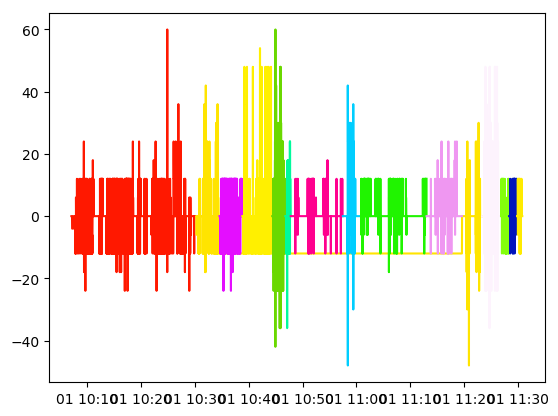

In [414]:

fig, ax = plt.subplots()
for i in big_df.sheet.unique():
    # Bumpers is duplicate
    color=uniqueish_color()
    #ax.plot(big_df[big_df.sheet==i].index, big_df[big_df.sheet==i]['Vertical'], color=color)
    ax.plot(big_df[big_df.sheet==i].index, pd.rolling_median(big_df[big_df.sheet==i]['Vertical'],30), color=color)
plt.show()

In [416]:
big_df.head()

,Vertical,Forward,Radial,Speed,Ignition,file,sheet,cat_id,hard_stop_on,speed_diff,speed_diff_1,speed_ma_100,time_sec
flat_time,,,,,,,,,,,,,
2018-05-01 10:07:01.000000000,0.0,24.0,0.0,1.0,1.0,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,0,NaN,NaN,NaN,2018-05-01 10:07:00.964000000
2018-05-01 10:07:01.020000000,0.0,36.0,0.0,1.0,1.0,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,0,0.0,NaN,NaN,2018-05-01 10:07:00.984000256
2018-05-01 10:07:01.040000256,0.0,36.0,0.0,1.0,1.0,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,0,0.0,0.0,NaN,2018-05-01 10:07:01.004000512
2018-05-01 10:07:01.060000256,0.0,24.0,0.0,1.0,1.0,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,0,0.0,0.0,NaN,2018-05-01 10:07:01.024000768
2018-05-01 10:07:01.080000256,0.0,24.0,-12.0,1.0,1.0,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,0,0.0,0.0,NaN,2018-05-01 10:07:01.044001024


In [421]:
research_dfa.keys()

Index(['Vertical', 'Radial', 'Forward', 'Vertical_std', 'Radial_std',
       'Forward_std', 'Vertical_max', 'Radial_max', 'Forward_max',
       'Vertical_min', 'Radial_min', 'Forward_min', 'cat_id', 'hard_stop_on'],
      dtype='object')

In [437]:
big_df['flat_time']=t
big_df['flat_time_sec']=big_df['flat_time'].dt.round('s')

In [441]:
# making the research dfa - second based 
research_dfa=big_df.groupby('flat_time_sec')['Vertical','Radial','Forward'].mean()\
    .join(big_df.groupby('flat_time_sec')['Vertical','Radial','Forward'].std(), rsuffix='_std')\
    .join(big_df.groupby('flat_time_sec')['Vertical','Radial','Forward'].max(), rsuffix='_max')\
    .join(big_df.groupby('flat_time_sec')['Vertical','Radial','Forward'].min(), rsuffix='_min')\
    .join(big_df.groupby('flat_time_sec')['cat_id'].max())\
    .join(big_df.groupby('flat_time_sec')['hard_stop_on'].max())\
     .join(big_df.groupby('flat_time_sec')['sheet'].max())

### some more plots

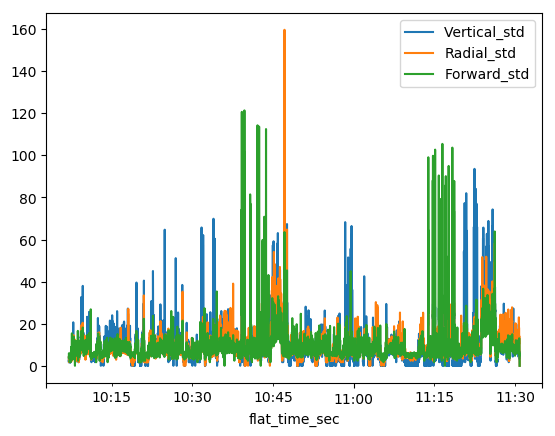

In [439]:
research_dfa[['Vertical_std','Radial_std','Forward_std']].plot()

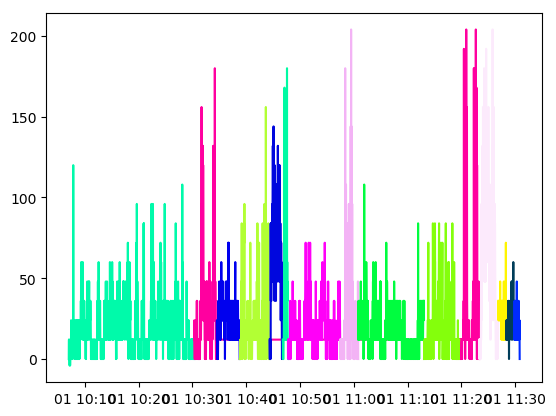

In [450]:
fig, ax = plt.subplots()
for i in big_df.sheet.unique():
    # Bumpers is duplicate
    color=uniqueish_color()
    #ax.plot(big_df[big_df.sheet==i].index, big_df[big_df.sheet==i]['Vertical'], color=color)
    ax.plot(research_dfa[research_dfa.sheet==i].index, \
            research_dfa[research_dfa.sheet==i]['Vertical'], color=color)

plt.show()

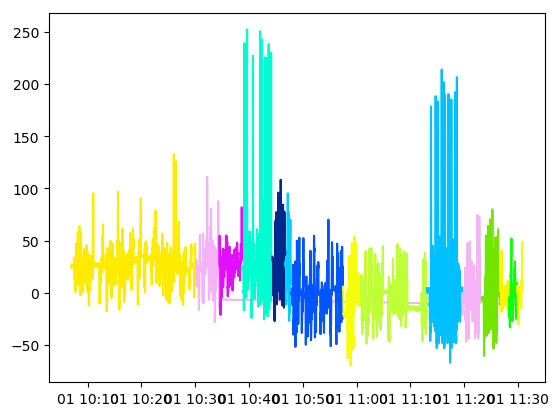

In [449]:
fig, ax = plt.subplots()
for i in big_df.sheet.unique():
    # Bumpers is duplicate
    color=uniqueish_color()
    #ax.plot(big_df[big_df.sheet==i].index, big_df[big_df.sheet==i]['Vertical'], color=color)
    ax.plot(research_dfa[research_dfa.sheet==i].index, \
            research_dfa[research_dfa.sheet==i]['Forward'], color=color)

plt.show()

## More

In [455]:
trn,test = train_test_split(research_dfa)
len(trn), len(test)

(3772, 1258)

In [456]:
len(research_dfa),sum(research_dfa.hard_stop_on==1)

(5030, 115)

In [459]:
research_dfa.keys()

Index(['Vertical', 'Radial', 'Forward', 'Vertical_std', 'Radial_std',
       'Forward_std', 'Vertical_max', 'Radial_max', 'Forward_max',
       'Vertical_min', 'Radial_min', 'Forward_min', 'cat_id', 'hard_stop_on',
       'sheet'],
      dtype='object')

In [460]:
predictive_features=['Vertical', 'Radial', 'Forward', 'Vertical_std', 'Radial_std',\
       'Forward_std', 'Vertical_max', 'Radial_max', 'Forward_max',\
       'Vertical_min', 'Radial_min', 'Forward_min']

In [468]:
models=[LogisticRegression(),svm.SVC(decision_function_shape='ovo')]
for model in models:
    # SVM is much slower
    model.fit(trn[predictive_features],trn['hard_stop_on'])
    print(model.score(test[predictive_features],test[['hard_stop_on']]))

0.9713831478537361
0.9737678855325914


In [470]:
np.max(models[0].predict_proba(test[predictive_features]),axis=0)

array([1.        , 0.73034996])

In [475]:
sum(models[0].predict_proba(test[predictive_features])>0.1)

array([1258,   64])

In [495]:
models[0].predict_proba(test[predictive_features])>0.1

array([[ True, False],
       [ True, False],
       [ True, False],
       ...,
       [ True,  True],
       [ True, False],
       [ True, False]])

In [528]:

cm = confusion_matrix(np.array(models[0].predict_proba(test[predictive_features])>0.1)[:,1], test[['hard_stop_on']])
cm

array([[1175,   19],
       [  50,   14]])

In [530]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(trn[predictive_features],trn['hard_stop_on'])        

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [531]:
cm = confusion_matrix(np.array(clf.predict_proba(test[predictive_features])>0.1)[:,1], test[['hard_stop_on']])
cm

array([[1185,   21],
       [  40,   12]])